

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Importing Skin Cancer Data**


To do: Take necessary actions to read the data

**Importing all the important libraries**

In [45]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [46]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.


In [47]:
# Defining the path for train and test images
train_path="./gdrive/MyDrive/CNN_assignment/Train/"
test_path="./gdrive/MyDrive/CNN_assignment/Test/"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [48]:
# Getting the image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [49]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [50]:
## Generates a Train Dataset from image files in a directory.
## we use seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing the images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [51]:
## Generates a Validation Dataset from image files in a directory.
## we use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing the images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [53]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize the data

Todo, create a code to visualize one instance of all the nine classes present in the dataset

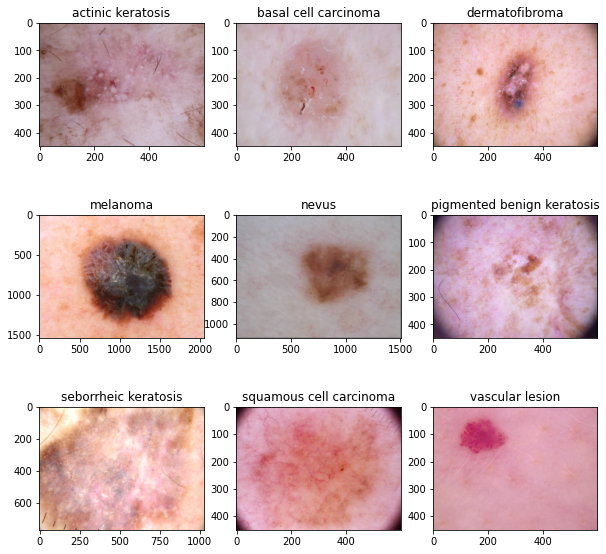

In [54]:
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


The image_batch is a tensor of the shape (32, 180, 180, 3). 
This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [55]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [56]:

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [57]:
### choose adam optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

Train the model

In [59]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 179s 668ms/step - loss: 2.0613 - accuracy: 0.2009 - val_loss: 2.0171 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 78ms/step - loss: 1.9763 - accuracy: 0.2528 - val_loss: 1.9822 - val_accuracy: 0.2796
Epoch 3/20
56/56 [==============================] - 4s 77ms/step - loss: 1.8932 - accuracy: 0.2824 - val_loss: 1.8464 - val_accuracy: 0.3445
Epoch 4/20
56/56 [==============================] - 4s 77ms/step - loss: 1.8077 - accuracy: 0.3320 - val_loss: 1.7489 - val_accuracy: 0.3669
Epoch 5/20
56/56 [==============================] - 4s 77ms/step - loss: 1.7033 - accuracy: 0.3711 - val_loss: 1.6350 - val_accuracy: 0.4027
Epoch 6/20
56/56 [==============================] - 4s 77ms/step - loss: 1.6109 - accuracy: 0.4068 - val_loss: 1.6481 - val_accuracy: 0.3781
Epoch 7/20
56/56 [==============================] - 4s 77ms/step - loss: 1.5328 - accuracy: 0.4414 - val_loss: 1.5694 - val_accuracy: 0.4273
Epoch 8/20
56/56 [===

Visualizing training results

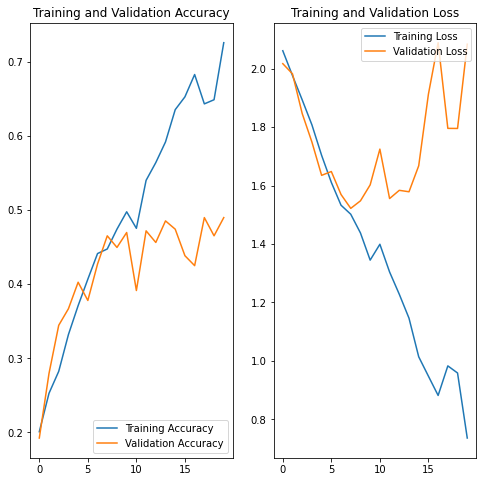

In [63]:
#list all data in history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit**

Finding on the first base model

The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

The accuracy is just around 75-80% because there are enough features to remember the pattern.

But again, it's too early to comment on the overfitting & underfitting debate

In [64]:
# choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

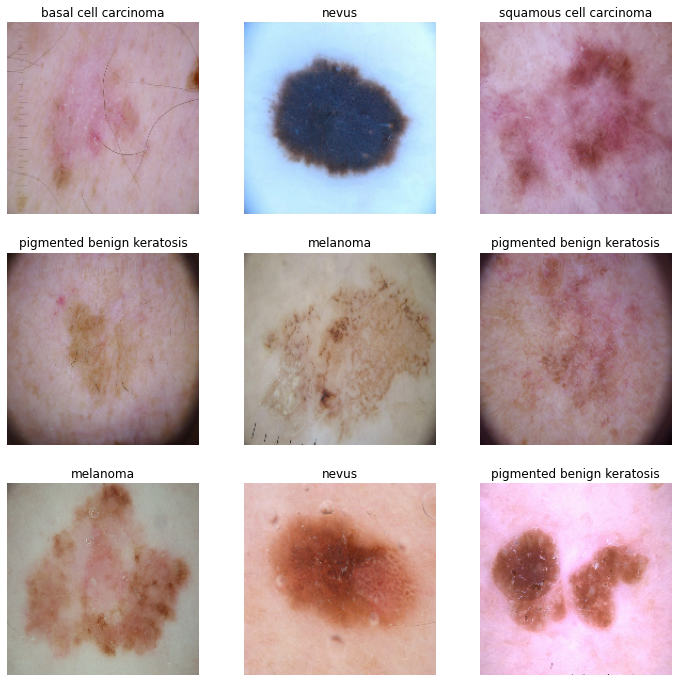

In [65]:
# visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Todo:

Create the model, compile and train the model

In [66]:
## use Dropout layer if there is an evidence of overfitting in findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


Compiling the model

In [67]:
### Compiling the model with adam optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model

In [68]:
## train model for 20 epochs
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 7s 93ms/step - loss: 2.0880 - accuracy: 0.1886 - val_loss: 2.0456 - val_accuracy: 0.2640
Epoch 2/30
56/56 [==============================] - 5s 88ms/step - loss: 2.0342 - accuracy: 0.2148 - val_loss: 2.0267 - val_accuracy: 0.2170
Epoch 3/30
56/56 [==============================] - 5s 87ms/step - loss: 2.0215 - accuracy: 0.2115 - val_loss: 1.9967 - val_accuracy: 0.2237
Epoch 4/30
56/56 [==============================] - 5s 87ms/step - loss: 1.9892 - accuracy: 0.2400 - val_loss: 1.9199 - val_accuracy: 0.2707
Epoch 5/30
56/56 [==============================] - 5s 89ms/step - loss: 1.9137 - accuracy: 0.2829 - val_loss: 1.8548 - val_accuracy: 0.3087
Epoch 6/30
56/56 [==============================] - 5s 87ms/step - loss: 1.8024 - accuracy: 0.3192 - val_loss: 1.7318 - val_accuracy: 0.3826
Epoch 7/30
56/56 [==============================] - 5s 86ms/step - loss: 1.7447 - accuracy: 0.3638 - val_loss: 1.6825 - val_accuracy: 0.3714
Epoch 8/30
56/56 [======

Visualizing the results

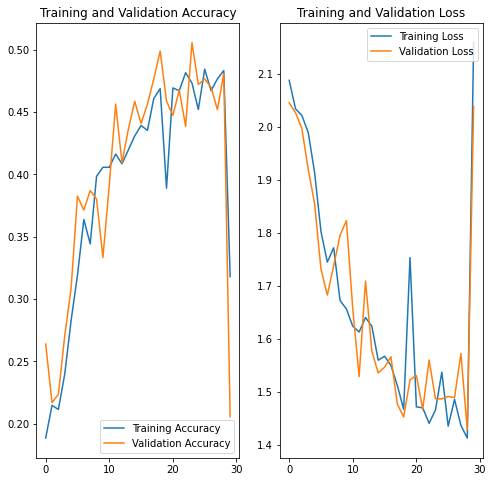

In [69]:
#list all data in history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?**

**Finding from Second Model**

There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

We can increase the epochs to increase the accuracy so it's too early for judgement

Todo: Find the distribution of classes in the training dataset.

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [70]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
1,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
2,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
3,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
4,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
...,...,...
2234,gdrive/MyDrive/CNN_assignment/Train/vascular l...,vascular lesion
2235,gdrive/MyDrive/CNN_assignment/Train/vascular l...,vascular lesion
2236,gdrive/MyDrive/CNN_assignment/Train/vascular l...,vascular lesion
2237,gdrive/MyDrive/CNN_assignment/Train/vascular l...,vascular lesion


In [71]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
1,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
2,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
3,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
4,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
...,...,...
2234,gdrive/MyDrive/CNN_assignment/Train/vascular l...,vascular lesion
2235,gdrive/MyDrive/CNN_assignment/Train/vascular l...,vascular lesion
2236,gdrive/MyDrive/CNN_assignment/Train/vascular l...,vascular lesion
2237,gdrive/MyDrive/CNN_assignment/Train/vascular l...,vascular lesion


<BarContainer object of 9 artists>

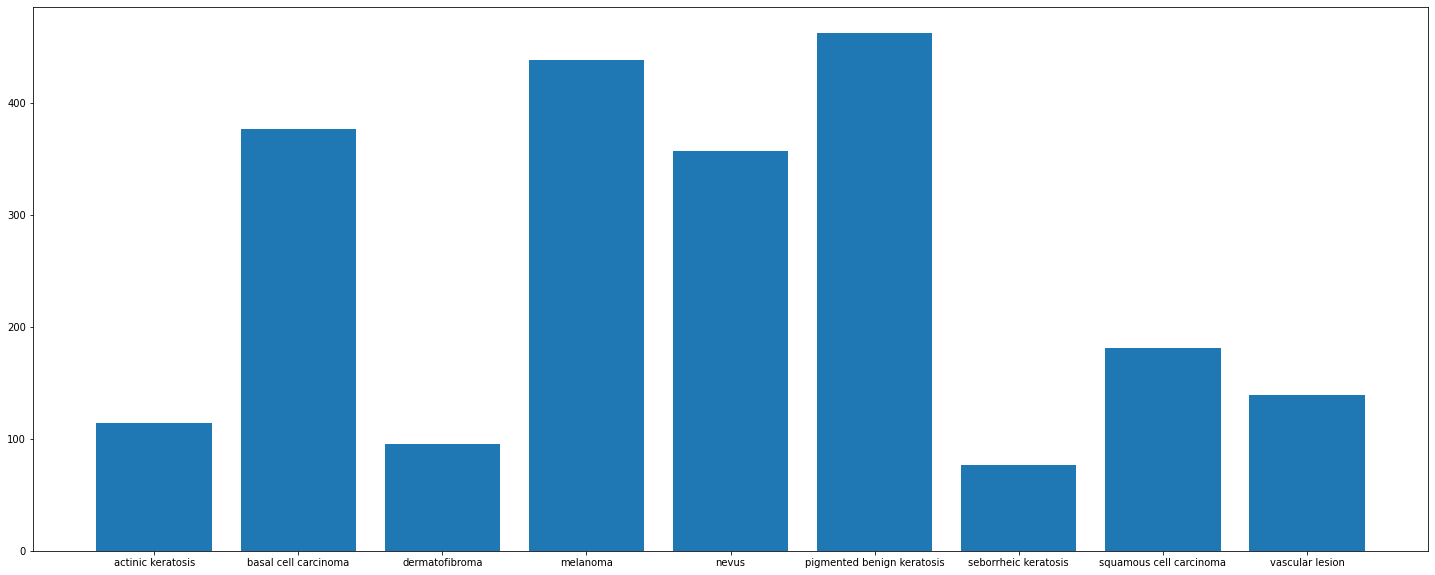

In [72]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

**Write your findings here:**

- Which class has the least number of samples?
- Which classes dominate the data in terms proportionate number of samples?

Ans-1 :- squamous cell carcinoma has least number of samples

Ans-2:- actinic keratosis and dermatofibroma have proportionate number of classes. melanoma and pigmented benign keratosis have proprtionate number of classes

In [73]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

Todo: Rectify the class imbalance

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [74]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [75]:
#path_to_training_dataset="./gdrive/MyDrive/CNN_assignment/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("./gdrive/MyDrive/CNN_assignment/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to ./gdrive/MyDrive/CNN_assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=964x720 at 0x7FBFA22B7F50>: 100%|██████████| 500/500 [01:00<00:00,  8.28 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to ./gdrive/MyDrive/CNN_assignment/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=961x649 at 0x7FBFA4D1F5D0>: 100%|██████████| 500/500 [00:41<00:00, 12.11 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to ./gdrive/MyDrive/CNN_assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBFA4C92F50>: 100%|██████████| 500/500 [00:44<00:00, 11.21 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to ./gdrive/MyDrive/CNN_assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBFA62D2210>: 100%|██████████| 500/500 [00:43<00:00, 11.38 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to ./gdrive/MyDrive/CNN_assignment/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7FBFA386A950>: 100%|██████████| 500/500 [00:44<00:00, 11.22 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to ./gdrive/MyDrive/CNN_assignment/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBFA233D650>: 100%|██████████| 500/500 [00:43<00:00, 11.37 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to ./gdrive/MyDrive/CNN_assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FBFA3874C10>: 100%|██████████| 500/500 [00:49<00:00, 10.20 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to ./gdrive/MyDrive/CNN_assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FC0382F7910>: 100%|██████████| 500/500 [00:50<00:00,  9.98 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to ./gdrive/MyDrive/CNN_assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBFBA6A28D0>: 100%|██████████| 500/500 [00:52<00:00,  9.49 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [76]:
data_dir_train1 = pathlib.Path("./gdrive/MyDrive/CNN_assignment/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [77]:

for i in class_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
1,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
2,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
3,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
4,gdrive/MyDrive/CNN_assignment/Train/actinic ke...,actinic keratosis
...,...,...
6734,gdrive/MyDrive/CNN_assignment/Train/output/vas...,vascular lesion
6735,gdrive/MyDrive/CNN_assignment/Train/output/vas...,vascular lesion
6736,gdrive/MyDrive/CNN_assignment/Train/output/vas...,vascular lesion
6737,gdrive/MyDrive/CNN_assignment/Train/output/vas...,vascular lesion


Lets see the distribution of augmented data after adding new images to the original training data.

In [78]:
new_df['Label'].value_counts()

pigmented benign keratosis    1406
melanoma                      1347
basal cell carcinoma          1146
nevus                         1044
squamous cell carcinoma        542
vascular lesion                413
actinic keratosis              328
dermatofibroma                 288
seborrheic keratosis           225
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Todo: Train the model on the data created using Augmentor

In [79]:
batch_size = 32
img_height = 180
img_width = 180

In [81]:
import pathlib
data_dir_train1=pathlib.Path("./gdrive/MyDrive/CNN_assignment/Train")

In [83]:
data_dir_train1

PosixPath('gdrive/MyDrive/CNN_assignment/Train')

Create a training dataset

In [84]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

2239


In [85]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


data_dir_train1=pathlib.Path("./gdrive/MyDrive/CNN_assignment/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 5392 files for training.


Create a validation dataset

In [86]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 1347 files for validation.


Create your model (make sure to include normalization)

In [88]:
## use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Compile your model (Choose optimizer and loss function appropriately)

In [89]:
## ### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train your model

In [90]:

##  train your model for 20 epochs
epochs =20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 38s 216ms/step - loss: nan - accuracy: 0.0211 - val_loss: nan - val_accuracy: 0.0230
Epoch 2/20
169/169 [==============================] - 35s 199ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 3/20
169/169 [==============================] - 36s 206ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 4/20
169/169 [==============================] - 34s 198ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 5/20
169/169 [==============================] - 34s 197ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 6/20
169/169 [==============================] - 34s 195ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 7/20
169/169 [==============================] - 35s 203ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 8/20
169/169 [==================

Visualize the model results

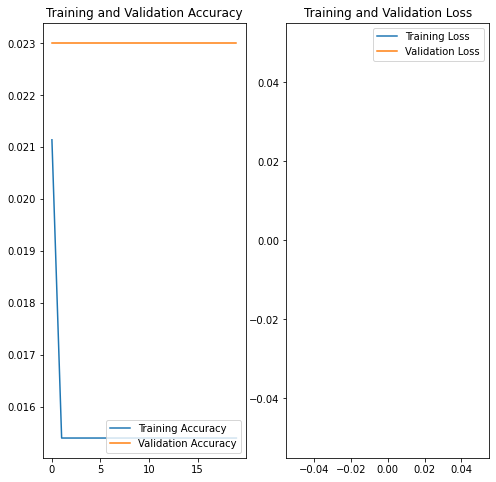

In [91]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?




*   Accuracy on training data has increased by using Augmentor library
*   Model is still overfitting
*   The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.
*   The Model can be further improved by tuning the hyperparameter

